## Data playground

In [22]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

### Testing transform on /r/Coronavirus

In [23]:
# Load data
data = pd.read_json('../data/coronavirus-m100.json')
data['distinguished'] = data['distinguished'].fillna(value='none')

**Basic idea**: Provided that a significant portion of score distributions are _heavily_ skewed towards low values, it is reasonable to claim most low-scoring comments are insignificant, and may be categorized the same. However, instead of choosing a random criteria (e.g. everything below 100 is insignificant), we aim to choose a more empirically consistent criteria.

To do this, we observe the nature of our data below...

count    203113.000000
mean         22.012097
std         251.003406
min        -991.000000
25%           1.000000
50%           1.000000
75%           3.000000
max       22357.000000
Name: score, dtype: float64

more percentiles:
75.000%: 3.000
80.000%: 5.000
90.000%: 14.000
95.000%: 41.000
97.500%: 103.000
99.000%: 319.880
99.900%: 3493.984
99.990%: 10427.386
99.999%: 16848.965


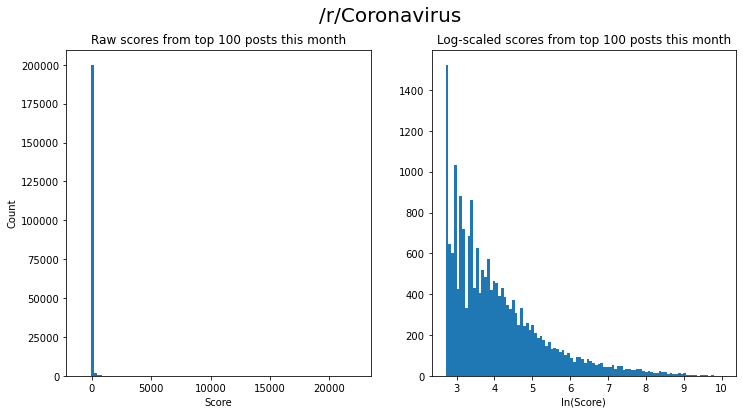

In [24]:
# basic info
print(data['score'].describe()); print()
print('more percentiles:')

percentiles = dict()
for i in (75, 80, 90, 95, 97.5, 99, 99.9, 99.99, 99.999):
    # store percentiles
    percentiles[i] = np.percentile(data['score'],i)
    print('{0:.3f}%: {1:.3f}'.format(i,percentiles[i]))

# take a look at score distribution...
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(data['score'], 100)

# try stripping "insignificant" comments
data_stripped = list(filter(lambda x: x > percentiles[90], data['score']))
ax2.hist(np.log(data_stripped), 100)

plt.suptitle('/r/Coronavirus', fontsize=20)

ax1.set_title('Raw scores from top 100 posts this month')
ax2.set_title('Log-scaled scores from top 100 posts this month')

ax1.set(xlabel='Score', ylabel='Count')
ax2.set(xlabel='ln(Score)')

plt.show()

### Do all subreddits follow the same pattern?

As seen above, especially in the percentile breakdown, the vast majority of comments on _/r/Coronavirus_ have a very low score. Even without the breakdowns and graphs, one could just look at the quartiles, mean, and std. A good place to start to get a better understanding was truncating everything up to the 90th percentile (which could be a candidate "insignificant" categorical criterion) and performing a natural log-transform to see a better shape.

In [56]:
# subreddits to look at...
subreddits = [
    'askreddit', 
    'conservative',
    'funny', 
    'gaming', 
    'news', 
    'pics', 
    'politics', 
    'sandersforpresident', 
    'technology', 
    'worldnews'
]

# percentile cutoff
P = 90
data = list()

# get data for all
for sub in subreddits:
    # load
    try:
        d = pd.read_json('../data/{0}-m100.json'.format(sub))
    except:
        # something went wrong...
        continue
    d['distinguished'] = d['distinguished'].fillna(value='none')
    # strip
    d_stripped = list(
        filter(
            # to pass, must be above P percentile
            lambda x: x > np.percentile(d['score'], P),
            d['score']
        )
    )
    data.append(d_stripped)

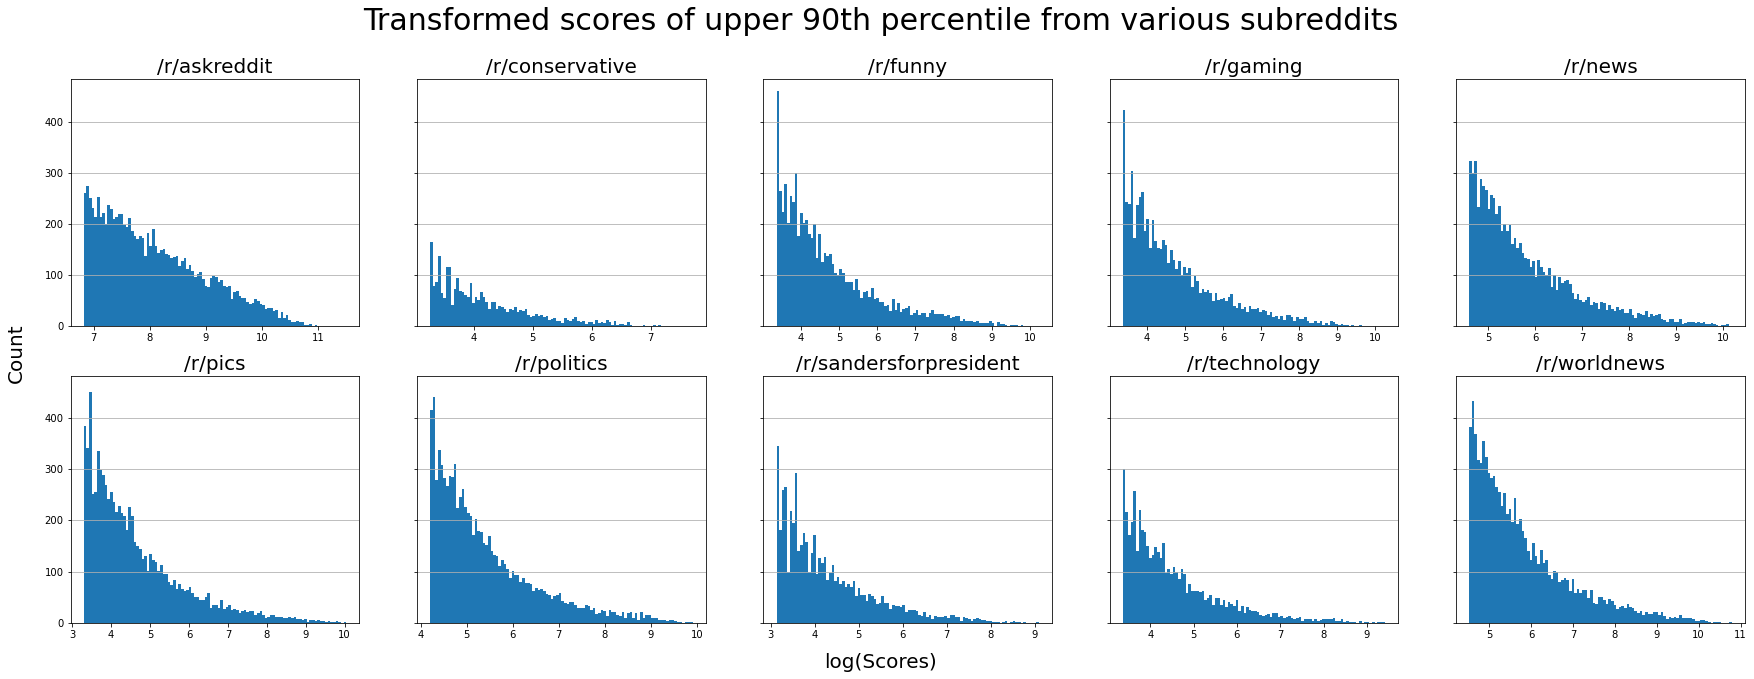

In [68]:
# plots (work with 10 subreddits)
fig, axs = plt.subplots(2, 5, figsize=(30, 10), sharey=True)

# top row 0-4, bottom row 5-9
i, bins = 0, 100
for r in range(axs.shape[0]):
    for c in range(axs.shape[1]):
        axs[r,c].hist(np.log(data[i]), bins)
        axs[r,c].grid(axis='y')
        axs[r,c].set_title('/r/{0}'.format(subreddits[i]), fontsize=20)
        i += 1

fig.suptitle('Transformed scores of upper {0}th percentile from various subreddits'.format(P), fontsize=30)
fig.text(0.5, 0.07, 'log(Scores)', ha='center', va='center', fontsize=20)
fig.text(0.1, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
plt.show()

As shown above, it can be seen each subreddit can have its own _unique_ score distribution. This illustrates that for different models, it is ideal to have dynamic criteria for categorization of comment significance, provided that every subreddit exhibits its own distribution.